In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

!pip install pmdarima

from pmdarima.arima import AutoARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [60]:
df = pd.read_csv('parkingLot.csv')
df = df.sort_values(by=['timestamp', 'vehicle_no'])
df['timestamp'] = pd.to_datetime(df['timestamp']) - pd.Timedelta(hours= 2)
df['date'] = df['timestamp'].dt.date

In [61]:
def is_one_character_apart(v1, v2):
    if pd.isna(v1) or pd.isna(v2):
        return False
    if len(v1) != len(v2):
        return False
    return sum(el1 != el2 for el1, el2 in zip(v1, v2)) == 1

In [62]:
entries = df[df['camera_id'] == 1].copy()
exits = df[df['camera_id'] == 2].copy()

In [63]:
print(entries)

       vehicle_no           timestamp  camera_id        date
15       MHBD3420 2024-09-12 03:00:00          1  2024-09-12
16       MHBL2555 2024-09-12 03:00:00          1  2024-09-12
9        MHBR3603 2024-09-12 03:00:00          1  2024-09-12
17       MHDS3083 2024-09-12 03:00:00          1  2024-09-12
2        MHEL6595 2024-09-12 03:00:00          1  2024-09-12
...           ...                 ...        ...         ...
106484   MHBB9719 2024-11-13 18:00:00          1  2024-11-13
106475   MHDF3718 2024-11-13 18:00:00          1  2024-11-13
106483   MHPN3450 2024-11-13 18:00:00          1  2024-11-13
106478   MHQJ4009 2024-11-13 18:00:00          1  2024-11-13
106471   MHVY8418 2024-11-13 18:00:00          1  2024-11-13

[53347 rows x 4 columns]


In [64]:
print(exits)

       vehicle_no           timestamp  camera_id        date
184      MHEL6595 2024-09-12 06:00:00          2  2024-09-12
204      MHGS9163 2024-09-12 06:00:00          2  2024-09-12
188      MHUN7063 2024-09-12 06:00:00          2  2024-09-12
182      MHYN4677 2024-09-12 06:00:00          2  2024-09-12
221      MHGH6189 2024-09-12 06:20:00          2  2024-09-12
...           ...                 ...        ...         ...
106691   MHSR8102 2024-11-13 22:00:00          2  2024-11-13
106676   MHTM4277 2024-11-13 22:00:00          2  2024-11-13
106681   MHUI0644 2024-11-13 22:00:00          2  2024-11-13
106690   MHVY8418 2024-11-13 22:00:00          2  2024-11-13
106687   MHYL8247 2024-11-13 22:00:00          2  2024-11-13

[53347 rows x 4 columns]


In [65]:
result_df = pd.DataFrame(columns=['date', 'entry_time', 'exit_time', 'time_spent'])
unmatched_entries = pd.DataFrame(columns=['vehicle_no', 'date', 'timestamp'])

for _, entry in entries.iterrows():
    entry_vehicle = entry['vehicle_no']
    entry_time = entry['timestamp']
    entry_date = entry['date']

    if pd.isna(entry_vehicle):
        new_unmatched = pd.DataFrame([{
            'vehicle_no': entry_vehicle,
            'date': entry_date,
            'timestamp': entry_time
        }])
        unmatched_entries = pd.concat([unmatched_entries, new_unmatched], ignore_index=True)
        continue

    possible_exits = exits[
        (exits['vehicle_no'] == entry_vehicle) &
        (exits['date'] == entry_date) &
        (exits['timestamp'] > entry_time)
    ]

    if possible_exits.empty:
        new_unmatched = pd.DataFrame([{
            'vehicle_no': entry_vehicle,
            'date': entry_date,
            'timestamp': entry_time
        }])
        unmatched_entries = pd.concat([unmatched_entries, new_unmatched], ignore_index=True)
    else:
        first_exit = possible_exits.iloc[0]
        exit_time = first_exit['timestamp']
        time_spent = exit_time - entry_time

        new_result = pd.DataFrame([{
            'date': entry_date,
            'entry_time': entry_time,
            'exit_time': exit_time,
            'time_spent': time_spent
        }])
        result_df = pd.concat([result_df, new_result], ignore_index=True)

        exits = exits.drop(index=first_exit.name)

print("\nMatched Entries and Exits:")
print(result_df)
print("\nUnmatched Entries:")
print(unmatched_entries)


Matched Entries and Exits:
             date          entry_time           exit_time      time_spent
0      2024-09-12 2024-09-12 03:00:00 2024-09-12 07:20:00 0 days 04:20:00
1      2024-09-12 2024-09-12 03:00:00 2024-09-12 06:40:00 0 days 03:40:00
2      2024-09-12 2024-09-12 03:00:00 2024-09-12 06:40:00 0 days 03:40:00
3      2024-09-12 2024-09-12 03:00:00 2024-09-12 08:20:00 0 days 05:20:00
4      2024-09-12 2024-09-12 03:00:00 2024-09-12 06:00:00 0 days 03:00:00
...           ...                 ...                 ...             ...
52386  2024-11-13 2024-11-13 18:00:00 2024-11-13 22:00:00 0 days 04:00:00
52387  2024-11-13 2024-11-13 18:00:00 2024-11-13 22:00:00 0 days 04:00:00
52388  2024-11-13 2024-11-13 18:00:00 2024-11-13 22:00:00 0 days 04:00:00
52389  2024-11-13 2024-11-13 18:00:00 2024-11-13 22:00:00 0 days 04:00:00
52390  2024-11-13 2024-11-13 18:00:00 2024-11-13 22:00:00 0 days 04:00:00

[52391 rows x 4 columns]

Unmatched Entries:
    vehicle_no        date           t

In [66]:
nan_unmatched = pd.DataFrame(columns=['vehicle_no', 'date', 'timestamp'])

for _, entry in unmatched_entries.iterrows():
    entry_vehicle = entry['vehicle_no']
    entry_date = entry['date']
    entry_time = entry['timestamp']

    if pd.isna(entry_vehicle):
        new_unmatched = pd.DataFrame([{
            'vehicle_no': entry_vehicle,
            'date': entry_date,
            'timestamp': entry_time
        }])
        nan_unmatched = pd.concat([nan_unmatched, new_unmatched], ignore_index=True)
        continue

    possible_exits = exits[
        (exits['timestamp'].dt.date == entry_date) &
        (exits['timestamp'] > entry_time) &
        (exits['vehicle_no'].apply(lambda x: is_one_character_apart(x, entry_vehicle)))
    ]

    if possible_exits.empty:
        new_unmatched = pd.DataFrame([{
            'vehicle_no': entry_vehicle,
            'date': entry_date,
            'timestamp': entry_time
        }])
        nan_unmatched = pd.concat([nan_unmatched, new_unmatched], ignore_index=True)
    else:
        first_exit = possible_exits.iloc[0]
        exit_time = first_exit['timestamp']
        time_spent = exit_time - entry_time

        new_result = pd.DataFrame([{
            'date': entry_date,
            'entry_time': entry_time,
            'exit_time': exit_time,
            'time_spent': time_spent
        }])
        result_df = pd.concat([result_df, new_result], ignore_index=True)

        exits = exits.drop(index=first_exit.name)

print("\nMatched Entries and Exits:")
print(result_df)
print("\nUnmatched Entries:")
print(nan_unmatched)


Matched Entries and Exits:
             date          entry_time           exit_time      time_spent
0      2024-09-12 2024-09-12 03:00:00 2024-09-12 07:20:00 0 days 04:20:00
1      2024-09-12 2024-09-12 03:00:00 2024-09-12 06:40:00 0 days 03:40:00
2      2024-09-12 2024-09-12 03:00:00 2024-09-12 06:40:00 0 days 03:40:00
3      2024-09-12 2024-09-12 03:00:00 2024-09-12 08:20:00 0 days 05:20:00
4      2024-09-12 2024-09-12 03:00:00 2024-09-12 06:00:00 0 days 03:00:00
...           ...                 ...                 ...             ...
52901  2024-11-13 2024-11-13 08:00:00 2024-11-13 12:40:00 0 days 04:40:00
52902  2024-11-13 2024-11-13 08:20:00 2024-11-13 14:00:00 0 days 05:40:00
52903  2024-11-13 2024-11-13 08:40:00 2024-11-13 15:00:00 0 days 06:20:00
52904  2024-11-13 2024-11-13 15:00:00 2024-11-13 20:40:00 0 days 05:40:00
52905  2024-11-13 2024-11-13 16:40:00 2024-11-13 20:40:00 0 days 04:00:00

[52906 rows x 4 columns]

Unmatched Entries:
    vehicle_no        date           t

In [67]:
for _, entry in nan_unmatched.iterrows():
    entry_vehicle = entry['vehicle_no']
    entry_date = entry['date']
    entry_time = entry['timestamp']

    if pd.isna(entry_vehicle):
        possible_exits = exits[
            (exits['timestamp'].dt.date == entry_date) &
            (exits['timestamp'] > entry_time) &
            ~(pd.isna(exits['vehicle_no']))
        ]

        first_exit = possible_exits.iloc[0]
        exit_time = first_exit['timestamp']
        time_spent = exit_time - entry_time

        new_result = pd.DataFrame([{
            'date': entry_date,
            'entry_time': entry_time,
            'exit_time': exit_time,
            'time_spent': time_spent
        }])
        result_df = pd.concat([result_df, new_result], ignore_index=True)

        exits = exits.drop(index=first_exit.name)
    else:
        possible_exits = exits[
            (exits['timestamp'].dt.date == entry_date) &
            (exits['timestamp'] > entry_time) &
            (pd.isna(exits['vehicle_no']))
        ]

        first_exit = possible_exits.iloc[0]
        exit_time = first_exit['timestamp']
        time_spent = exit_time - entry_time

        new_result = pd.DataFrame([{
            'date': entry_date,
            'entry_time': entry_time,
            'exit_time': exit_time,
            'time_spent': time_spent
        }])
        result_df = pd.concat([result_df, new_result], ignore_index=True)

        exits = exits.drop(index=first_exit.name)

print("\nMatched Entries and Exits:")
print(result_df)
print("\nUnmatched Exits:")
print(exits)


Matched Entries and Exits:
             date          entry_time           exit_time      time_spent
0      2024-09-12 2024-09-12 03:00:00 2024-09-12 07:20:00 0 days 04:20:00
1      2024-09-12 2024-09-12 03:00:00 2024-09-12 06:40:00 0 days 03:40:00
2      2024-09-12 2024-09-12 03:00:00 2024-09-12 06:40:00 0 days 03:40:00
3      2024-09-12 2024-09-12 03:00:00 2024-09-12 08:20:00 0 days 05:20:00
4      2024-09-12 2024-09-12 03:00:00 2024-09-12 06:00:00 0 days 03:00:00
...           ...                 ...                 ...             ...
53342  2024-11-09 2024-11-09 07:20:00 2024-11-09 13:20:00 0 days 06:00:00
53343  2024-11-09 2024-11-09 07:20:00 2024-11-09 13:20:00 0 days 06:00:00
53344  2024-11-09 2024-11-09 07:20:00 2024-11-09 13:20:00 0 days 06:00:00
53345  2024-11-09 2024-11-09 07:20:00 2024-11-09 13:20:00 0 days 06:00:00
53346  2024-11-09 2024-11-09 07:20:00 2024-11-09 13:20:00 0 days 06:00:00

[53347 rows x 4 columns]

Unmatched Exits:
Empty DataFrame
Columns: [vehicle_no, ti

In [68]:
mean_time_df = result_df.groupby('date', as_index=False)['time_spent'].mean()
print(mean_time_df)

          date                time_spent
0   2024-09-12 0 days 04:12:46.591422121
1   2024-09-13 0 days 06:28:03.559950556
2   2024-09-14 0 days 08:13:58.054054054
3   2024-09-15 0 days 08:57:20.074557315
4   2024-09-16 0 days 08:24:07.686832740
..         ...                       ...
58  2024-11-09 0 days 05:09:21.589403973
59  2024-11-10 0 days 04:46:07.372881355
60  2024-11-11 0 days 04:40:36.231884057
61  2024-11-12 0 days 04:49:54.044665012
62  2024-11-13 0 days 05:12:19.052496798

[63 rows x 2 columns]


In [69]:
ts_time_df = mean_time_df['time_spent']
ts_time_df = ts_time_df.dt.total_seconds()
print(ts_time_df)

0     15166.591422
1     23283.559951
2     29638.054054
3     32240.074557
4     30247.686833
          ...     
58    18561.589404
59    17167.372881
60    16836.231884
61    17394.044665
62    18739.052497
Name: time_spent, Length: 63, dtype: float64


In [70]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

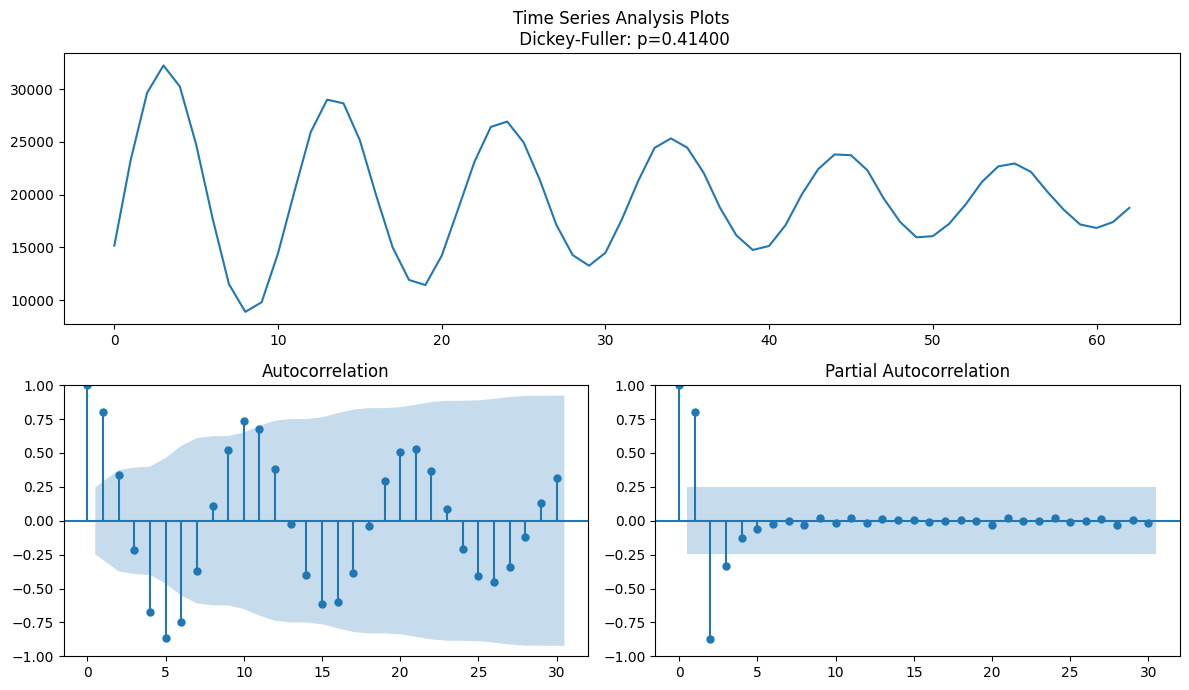

In [71]:
tsplot(ts_time_df, lags=30)

In [72]:
result = adfuller(ts_time_df)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.733386214742735
p-value: 0.4139981444601413


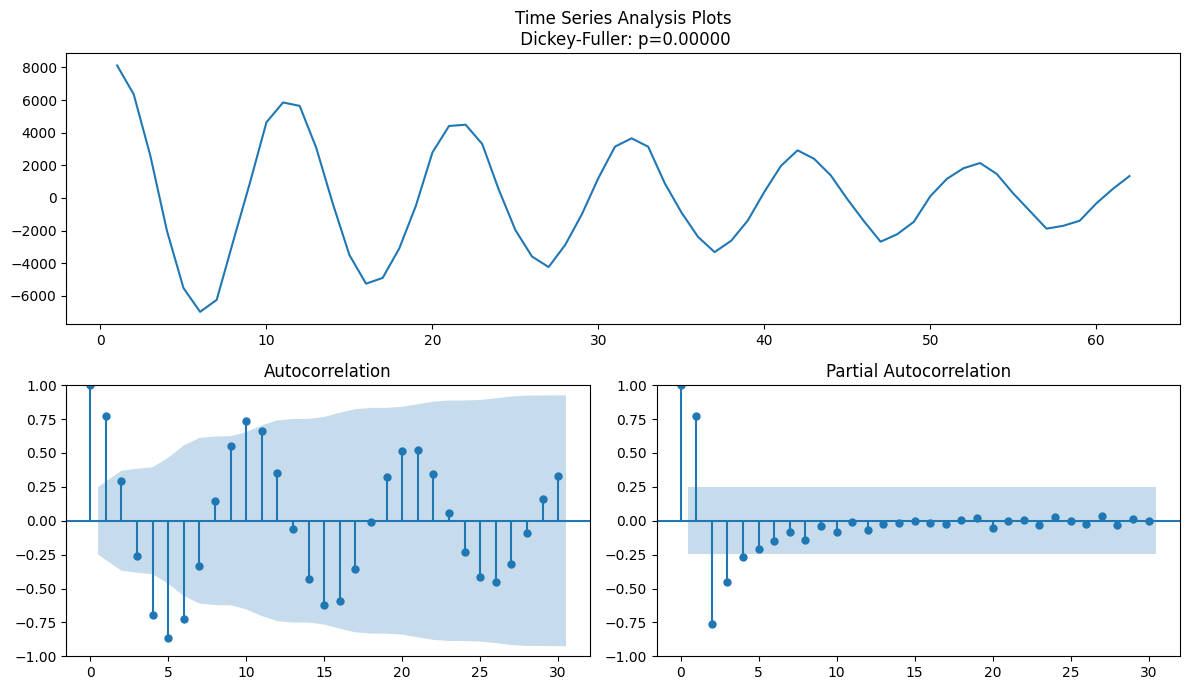

In [73]:
ts_parkingTime = ts_time_df.diff().dropna()
tsplot(ts_parkingTime, lags=30)

In [74]:
result = adfuller(ts_parkingTime)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -8.344488703723336
p-value: 3.1118918629619846e-13


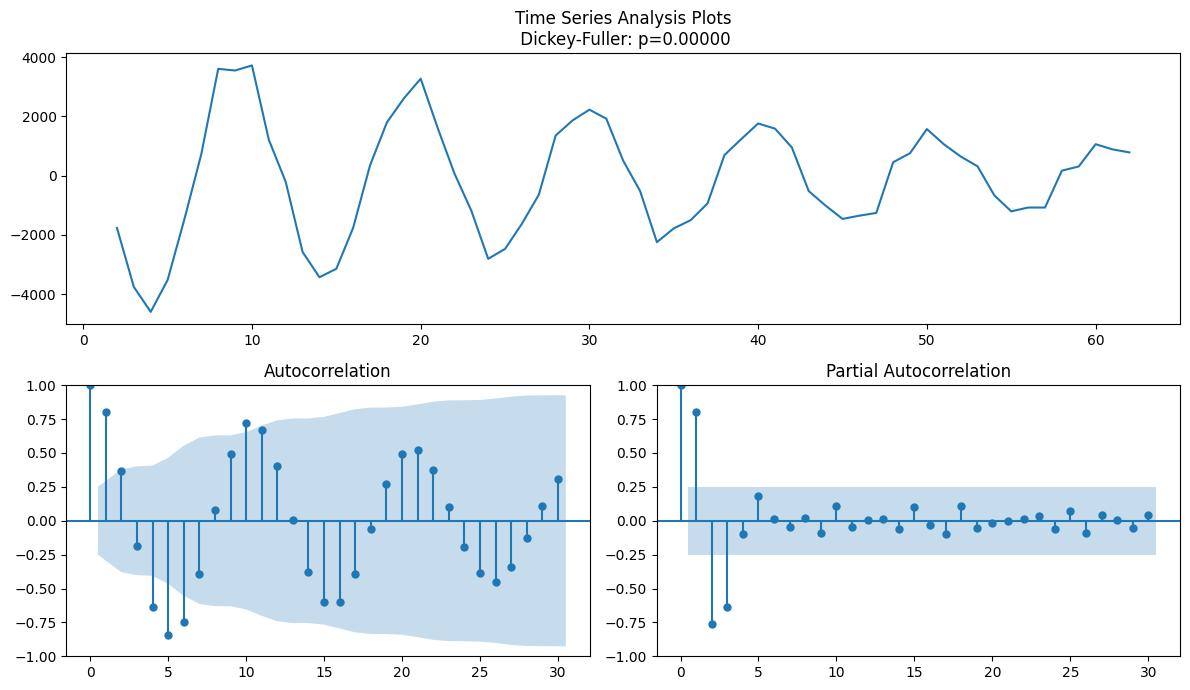

In [75]:
ts_parkingTime_diff = ts_parkingTime.diff().dropna()
tsplot(ts_parkingTime_diff, lags=30)

In [76]:
result = adfuller(ts_parkingTime_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -7.068222333745255
p-value: 5.015640063090612e-10


In [77]:
train_size = int(len(ts_time_df) * 0.8)
train, test = ts_time_df[:train_size], ts_time_df[train_size:]

model = AutoARIMA(suppress_warnings=True, trace=True, d=1, error_action='ignore', seasonal=True, m=7, stepwise=True)
model.fit(train)

n_test = len(test)
forecast, conf_int = model.predict(n_periods=n_test, return_conf_int=True)

forecast_index = test.index
forecast_series = pd.Series(forecast, index=forecast_index)

mae = mean_absolute_error(test, forecast_series)

mape = np.mean(np.abs((test - forecast_series) / test)) * 100

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=7.07 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=943.887, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=870.291, Time=0.75 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=941.898, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=886.026, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=814.679, Time=1.03 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=813.602, Time=4.44 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=821.747, Time=2.18 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=867.327, Time=0.47 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=748.614, Time=0.65 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=753.312, Time=0.42 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=747.447, Time=0.40 se

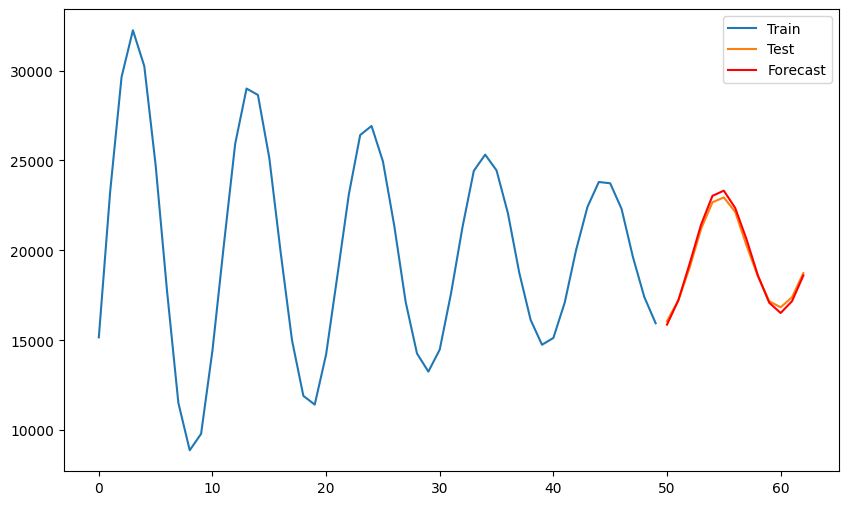

MAE: 210.48
MAPE: 1.07%


In [78]:
n_periods = len(test)
forecast = model.predict(n_periods=n_periods)

plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")